# 01 - Explore MediaPipe Hand Landmarks

This notebook serves as an initial test to verify that MediaPipe's hand detection and landmark extraction are working correctly on the ASL Alphabet dataset.

## Goals

- Load sample images from the dataset
- Run MediaPipe's hand tracking on each image
- Visualize detected hand landmarks to ensure they are correctly positioned
- Extract and flatten the 21 hand keypoints (x, y, z) into a 63-dimensional feature vector
- Confirm that the output is consistent, clean, and usable for model training

This step ensures that our preprocessing pipeline is valid before we move on to large-scale dataset processing and model training.

In [1]:
import os
import random
from pathlib import Path
from typing import List, Optional, Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

In [5]:
def get_keypoints_from_image(image_path: str) -> Optional[List[np.ndarray]]:
    """
    Extract 21 hand landmarks (x, y, z) from a single image using MediaPipe.

    Preconditions:
    - `image_path` must be a valid image file.

    Returns:
        np.ndarray or None: shape (21, 3) if hand is detected, otherwise None.
    """
    mp_hands = mp.solutions.hands
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    with mp_hands.Hands(static_image_mode=True, max_num_hands=2) as hands:
        results = hands.process(image_rgb)
        if not results.multi_hand_landmarks:
            return None
        keypoints_list = []
        for hand_landmarks in results.multi_hand_landmarks:
            keypoints = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark], dtype=np.float32)
            keypoints_list.append(keypoints)
        return keypoints_list

In [6]:
def select_random_images(directory: Path, k: int = 5) -> List[Path]:
    """
    Select *k* random image files from a directory (recursively).

    Preconditions:
    - Directory must exist and contain ≥ k image files.

    Returns:
        List[Path]: list of k image paths.
    """
    if not directory.exists():
        raise FileNotFoundError(directory)
    image_exts = {".jpg"}
    images = [img for img in directory.rglob("*") if img.suffix.lower() in image_exts]
    if len(images) < k:
        raise ValueError(f"Directory contains only {len(images)} image(s). Need ≥{k}.")
    return random.sample(images, k)


In [13]:
def draw_landmarks_on_image(
    image_bgr: np.ndarray,
    landmarks: np.ndarray,
    color: Tuple[int, int, int] = (0, 0, 255),
    radius: int = 4
) -> np.ndarray:
    """
    Draw landmark points on an image.

    Preconditions:
    - `landmarks` is (21, 3) in normalized coordinates.

    Returns:
        Annotated image (BGR).
    """
    h, w = image_bgr.shape[:2]
    annotated = image_bgr.copy()

    for x_norm, y_norm, _ in landmarks:
        cx, cy = int(x_norm * w), int(y_norm * h)
        cv2.circle(annotated, (cx, cy), radius, color, -1)

    return annotated


W0000 00:00:1751223721.260111   32311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751223721.272325   32311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751223721.294270   32323 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751223721.303482   32323 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751223721.330965   32335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751223721.342719   32335 inference_feedback_manager.cc:114] Feedback manager 

[WARN] No hand detected in: G2638.jpg
[WARN] No hand detected in: space427.jpg


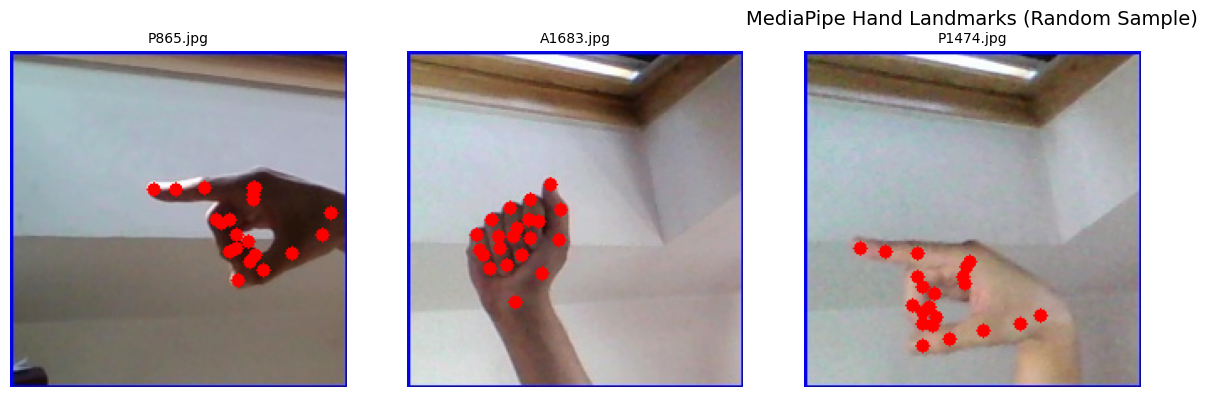

In [17]:
# Set your dataset folder here
DATASET_PATH = Path("../data/raw/asl_alphabet_train/")
K = 5  # Number of random samples

sample_paths = select_random_images(DATASET_PATH, k=K)
annotated_imgs = []
successful_paths = []

for path in sample_paths:
    hand_list = get_keypoints_from_image(str(path))  # list[np.ndarray] or None

    if not hand_list:
        print(f"[WARN] No hand detected in: {path.name}")
        continue

    keypoints = hand_list[0]  # (21, 3) array from the first hand
    img = cv2.imread(str(path))
    annotated = draw_landmarks_on_image(img, keypoints)
    annotated_imgs.append(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    successful_paths.append(path.name)

# Plot the results
cols = min(K, 5)
rows = (len(annotated_imgs) + cols - 1) // cols
plt.figure(figsize=(4 * cols, 4 * rows))

for idx, (img_rgb, title) in enumerate(zip(annotated_imgs, successful_paths), 1):
    plt.subplot(rows, cols, idx)
    plt.imshow(img_rgb)
    plt.title(title, fontsize=10)
    plt.axis("off")

plt.suptitle("MediaPipe Hand Landmarks (Random Sample)", fontsize=14)
plt.tight_layout()
plt.show()
